In [9]:
# %%capture --no-stderr
# %pip install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas


In [10]:
import getpass
import os
from dotenv import load_dotenv
from typing import Annotated
from langchain_experimental.tools import PythonREPLTool
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
import numpy as np
from langchain.tools import tool, Tool

python_repl_tool = PythonREPLTool()
load_dotenv()

True

In [11]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

In [12]:
members = ["DataAgent", "CodeAgent"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    " DataAgent can provide you data that can be used for further analisys"
    " For example it can provide you data for CodeAgent to create plot"
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal[*options]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o-mini")


def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

In [13]:
@tool
def get_data():
    """
    fetches data to create plot
    """
    
    data = {
    'Month': ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
    'Sales': np.random.randint(2000, 5000, size=12)
    }
    return str(data)
    


data_agent = create_react_agent(llm, tools=[get_data], prompt="dupa")
data_agent = functools.partial(agent_node, agent=data_agent, name="DataAgent")



# You can create the tool to pass to an agent
code_executor_tool = Tool(
    name="python code executor",
    description="A Python code executor. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl_tool.run,
)

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_react_agent(llm, tools=[python_repl_tool, code_executor_tool])

code_node = functools.partial(agent_node, agent=code_agent, name="CodeAgent")

workflow = StateGraph(AgentState)
workflow.add_node("DataAgent", data_agent)
workflow.add_node("CodeAgent", code_node)
workflow.add_node("supervisor", supervisor_agent)

In [14]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

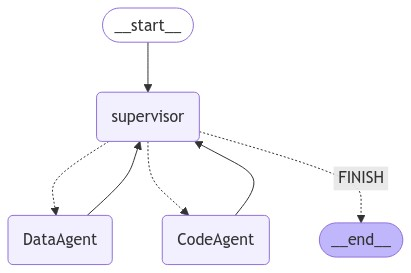

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [16]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Create plot showing data")
        ]
    }
):

    if "__end__" not in s:
    
        print(s)
        print("----")

{'supervisor': {'next': 'DataAgent'}}
----


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT